# 2 Option pricing using different techniques
### Compare the performance of option pricing with Monte Carlo simulation of a geometric Brownian motion and with a binary tree. To get a realistic input value for the volatility, estimate it from (a) historical stock data or (b) from option prices. Take data for some stock from yahoo or any other source. Indicate clearly in the documentation which date and which underlying you use. Include the code and the data for the estimation of the implied volatility in your project.

### Price a plain vanilla European option, produce the Greeks and least two of the following options: Corridor, knock-in, knock-out, American, Asian, digital option, Bermuda, Quanto. Try to price an American digital option. Discuss the results.
Note: not all options can be priced equally well with a Monte Carlo and a binary tree. Briefly discuss why in your report.


In [1]:
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import math
from itertools import permutations
from itertools import product
import datetime
import pandas_datareader as pdr
import yfinance as yf
%matplotlib inline

#### Classic libraries of Python, itertools useful for binarytrees paths (permutations)
#### Matplotlip inline ----> why ?
#### yfinance for data

In [2]:
start_date=datetime.datetime(2017,11,28)
end_date=datetime.datetime(2023,11,28)
tickers = 'TSLA'
prices = yf.download(tickers, start=start_date, end=end_date)
historical = prices['Adj Close'].dropna(how='all')
ret = historical.pct_change()[1:]
len(ret)

[*********************100%%**********************]  1 of 1 completed


1508

#### Choose any Ticker available on Yahoo! to price options for any security, our sample is composed of 1508 observations (daily returns).

In [3]:
historical = prices['Adj Close'].dropna(how='all')
ret = historical.pct_change()[1:]
days = len(ret)
sample_mean_tsla = np.mean(ret)
sample_std_tsla = np.std(ret, ddof=1) #We use one DoF as we estimate the sample mean (Matteo add something maybe)
lastPrice= S0 = historical.iloc[-1] #Last price very important in any stochastic process (starting point) 
sample_mean_tsla,sample_std_tsla, lastPrice

(0.0024043663221886644, 0.040156388904390154, 236.0800018310547)

#### We now have deriveda realistic input value for the volatility, we have done so by estimating the sample variance of a) historical stock data

## plain vanilla European Option

### Monte Carlo Simulation of a geometric Brownian motion

In [4]:
def monte_carlo_option_price(S, K, r, T, vol, num_simulations,opttype='call'):
    dt = 1/252  # Time step, assuming 252 trading days
    num_days = int(T * 252)  # Number of days until expiration

    simulated_prices = np.zeros((num_simulations, num_days))

    for i in range(num_simulations):
        price_path = np.zeros(num_days )
        price_path[0] = S

        for day in range(1, num_days):
            drift = (r - 0.5 * vol ** 2) * dt
            diffusion = vol * np.sqrt(dt) * np.random.normal(0, 1)
            price_t = price_path[day - 1] * np.exp(drift + diffusion)
            price_path[day] = price_t

        simulated_prices[i, :] = price_path

    if opttype.lower() == 'call':
        
        option_payoffs = np.maximum(simulated_prices[:, -1] - K, 0)  # Payoff for call option at expiration
    elif opptype.lower() == 'put':
    
        option_payoffs = np.maximum(K - simulated_prices[:, -1], 0)  # Payoff for put option at expiration
    else:
        raise ValueError("Invalid option type. Use 'call' for call or 'put' for put.")
    option_price = np.exp(-r * T) * np.mean(option_payoffs)

    return option_price, simulated_prices

In [5]:
# Option parameters
S = S0  # Current stock price
K = 260  # Strike price
r = 0.05045  # Risk-free interest rate
T = 1  # Time to expiration (in years)
vol = sample_std_tsla  # Volatility
num_simulations = 1000 # Number of Monte Carlo simulations, Higher number = Higher Precision = Higher Processing Power Needed

#### Modify the parameter to fit the macroeconomic context and to tailor your option

In [8]:
option_price, price_paths = monte_carlo_option_price(S, K, r, T, vol, num_simulations,'call') 
print("Price:", option_price, "$") #Here you choose between call and put

Price: 0.5872692806385673 $


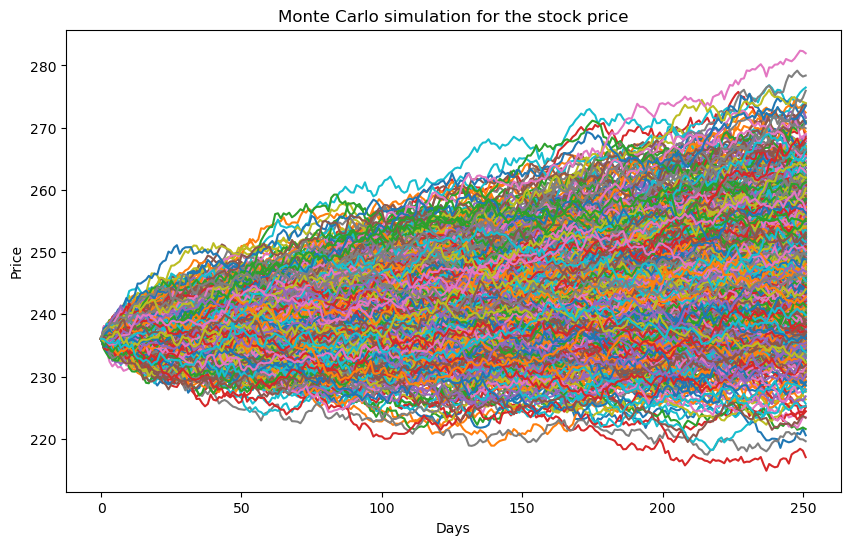

In [9]:
plt.figure(figsize=(10, 6))
for i in range(num_simulations):
    plt.plot(price_paths[i, :], label=f'Simulazione {i + 1}')

plt.title('Monte Carlo simulation for the stock price')
plt.xlabel('Days')
plt.ylabel('Price')
plt.show()

#### Greeks for this option

In [7]:
opttype = 'call'
def calculate_european_greeks(S, K, r, T, vol, num_simulations, opttype):
    # Define the small changes for each Greek calculation
    
    delta_S = 0.01 * S
    delta_vol = 0.01 * vol
    delta_T = 1 / 252
    delta_r = 0.01

    # Calculate the base option price
    base_price, _ = monte_carlo_option_price(S, K, r, T, vol, num_simulations, opttype)

    # Delta
    if greek == 'delta':
        price_up, _ = monte_carlo_option_price(S + delta_S, K, r, T, vol, num_simulations, opttype)
        greek_value = (price_up - base_price) / delta_S

    # Vega
    elif greek == 'vega':
        price_vol_up, _ = monte_carlo_option_price(S, K, r, T, vol + delta_vol, num_simulations, opttype)
        greek_value = (price_vol_up - base_price) / delta_vol

    # Theta
    elif greek == 'theta':
        price_later, _ = monte_carlo_option_price(S, K, r, T + delta_T, vol, num_simulations, opttype)
        greek_value = (base_price - price_later) / delta_T  

    # Gamma
    elif greek == 'gamma':
        price_up, _ = monte_carlo_option_price(S + delta_S, K, r, T, vol, num_simulations, opttype)
        price_down, _ = monte_carlo_option_price(S - delta_S, K, r, T, vol, num_simulations, opttype)
        delta_up = (price_up - base_price) / delta_S
        delta_down = (base_price - price_down) / delta_S
        greek_value = (delta_up - delta_down) / (2 * delta_S)

    # Rho
    elif greek == 'rho':
        price_r_up, _ = monte_carlo_option_price(S, K, r + delta_r, T, vol, num_simulations, opttype)
        greek_value = (price_r_up - base_price) / delta_r

    return greek_value

# Calculate and print all the Greeks
greeks_to_calculate = ['delta', 'vega', 'theta', 'gamma', 'rho']
for greek in greeks_to_calculate:
    greek_value = calculate_european_greeks(S, K, r, T, vol, num_simulations, opttype)
    print(f"{greek.capitalize()} of the European option: {greek_value}")

Delta of the European option: 0.13897015013924213
Vega of the European option: 127.97790568496228
Theta of the European option: -8.02766217056568
Gamma of the European option: 0.009631661194407868
Rho of the European option: 30.111587068216892


#### Comment on the Greeks ... 

### Binary Tree 

In [10]:
N = 36# Number of Steps ....
T = 1 # Still in Years
S = S0 = lastPrice
dt = T/N
K = 260 # Stike Price
r = 0.05045

In [11]:
u = np.exp(sample_std_tsla * np.sqrt(dt)) #Cox, Ross and Rubinstein (CRR) #Parameters of the BT
d = 1/u

In [15]:
def binomial_tree_european(K,T,S0,r,N,vol,opttype='call'):
    #precompute constants
    dt = T/N
    u = np.exp(vol * np.sqrt(dt)) #Cox, Ross and Rubinstein (CRR)
    d = 1/u
    q = (np.exp(r*dt) - d) / (u-d)
    disc = np.exp(-r*dt)

    # initialise asset prices at maturity - Time step N
    S = np.zeros(N+1)
    S[0] = S0*d**N #you are taking the worst scenario 
    for j in range(1,N+1):
        S[j] = S[j-1]*u/d  # you're doing like a zig zag at time T to obtain all the prices

    # initialise option values at maturity
    C = np.zeros(N+1)
    for j in range(0,N+1):
        if opttype.lower() == 'put':
            C[j] = max(0, K - S[j])
        elif opttype.lower()=='call':
            C[j] = max(0, S[j] - K)
        else:
            raise ValueError("Invalid option type. Use 'call' for call or 'put' for put.")

       
    # step backwards through tree
    for i in np.arange(N,0,-1):
        for j in range(0,i):
            C[j] = disc * ( q*C[j+1] + (1-q)*C[j] )

    return C[0]

print("Price:",binomial_tree_european(K,T,S,r,N,vol,opttype='call'),"$") # Choose call or put here

Price: 0.5318703931520848 $


In [18]:
opttype = 'call' # Choose call or put here

def calculate_european_bingreeks(K,T,S,r,N,vol,opttype):
    # Define the small changes for each Greek calculation
    delta_S = 0.01 * S
    delta_T = 1 / 252
    delta_r = 0.01
    delta_u = np.exp(sample_std_tsla + (0.01 *sample_std_tsla)  * np.sqrt(dt))
    
    # Calculate the base option price
    base_price = binomial_tree_european(K,T,S,r,N,vol,opttype)

    # Delta
    if greek == 'delta':
        price_up = binomial_tree_european(K,T,S + delta_S,r,N,vol,opttype)
        greek_value = (price_up - base_price) / delta_S

    # Vega
    elif greek == 'vega':
        price_vol_up = binomial_tree_european(K,T,S,r,N,vol,opttype)
        greek_value = (price_vol_up - base_price) / delta_u

    # Theta
    elif greek == 'theta':
        price_later = binomial_tree_european(K,T+delta_T,S,r,N,u,d,opttype)
        greek_value = (base_price - price_later) / delta_T  # Note that theta is often negative

    # Gamma
    elif greek == 'gamma':
        price_up = binomial_tree_european(K,T,S+delta_S,r,N,u,d,opttype)
        price_down = binomial_tree_european(K,T,S-delta_S,r,N,u,d,opttype)
        delta_up = (price_up - base_price) / delta_S
        delta_down = (base_price - price_down) / delta_S
        greek_value = (delta_up - delta_down) / (2 * delta_S)

    # Rho
    elif greek == 'rho':
        price_r_up = binomial_tree_european(K,T,S,r+delta_r,N,u,d,opttype)
        greek_value = (price_r_up - base_price) / delta_r

    return greek_value

# Example usage
S0 = lastPrice  # Current stock price
K = 260  # Strike price
r = 0.05  # Risk-free interest rate
T = 1  # Time to expiration in years
vol = sample_std_tsla  # Volatility
num_simulations = 100


# Calculate and print all the Greeks
greeks_to_calculate = ['delta', 'vega', 'theta', 'gamma', 'rho']
for greek in greeks_to_calculate:
    greek_value = calculate_european_bingreeks(K,T,S,r,N,u,d,'call')
    print(f"{greek.capitalize()} of the European option: {greek_value}")

TypeError: binomial_tree_european() takes from 6 to 7 positional arguments but 8 were given

#### Small different in price between the 2 methods (we need to quantify it)

### American